In [15]:
import ugradio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd
import new_interf
import seaborn as sns

from datetime import datetime, timedelta


In [75]:
m17_data = pd.read_csv('long_obs_data2.csv')
other_data=pd.read_csv('long_obs_data.csv')

m17_volts = m17_data['Voltages']
m17_times = m17_data['Times']
#print(datetime.utcfromtimestamp(moon_times[0]).strftime('%Y-%m-%d %H:%M:%S'), "in UTC")
def utc_to_local(unix_time):
    utc_dt = datetime.utcfromtimestamp(unix_time)
    time = utc_dt - timedelta(hours=8)
    return time.strftime('%Y-%m-%d %H:%M:%S')
t= utc_to_local(m17_times[0])
print(t, "local time")
m17_data.drop('Unnamed: 0', axis=1, inplace=True) #drop redundant index columnn to clean dataframe
other_data.drop('Unnamed: 0', axis=1, inplace=True) #drop redundant index columnn to clean dataframe


print(m17_times[0], "time of observation in bullshit unix")
m17_times -= m17_times[0]  # this is shorthand for moontime = itself minus moontime[0]
dt = m17_times[1] - m17_times[0]  # this is the time step between samples
print(len('long_obs_data2.csv'))

2022-03-16 08:29:43 local time
1647448183.909691 time of observation in bullshit unix
18


,Voltages,Times
0,0.000036,1.647448e+09
1,0.000035,1.647448e+09
2,0.000034,1.647448e+09
3,0.000030,1.647448e+09
4,0.000029,1.647448e+09
...,...,...
2102,-0.000138,1.647459e+09
2103,-0.000139,1.647459e+09
2104,-0.000141,1.647459e+09
2105,-0.000137,1.647459e+09


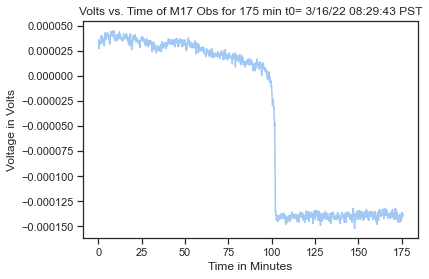

In [19]:
plt.figure()
plt.xlabel("Time in Minutes")
plt.ylabel("Voltage in Volts")
plt.title("Volts vs. Time of M17 Obs for 175 min t0= 3/16/22 08:29:43 PST")
plt.plot(m17_times/60, m17_volts)
# we can see the frequencies are getting smaller 
# this happens at the horizons 
# frequency changes as the cosine of the angle (highest at zentih and lowest at horizon)

<IPython.core.display.Javascript object>


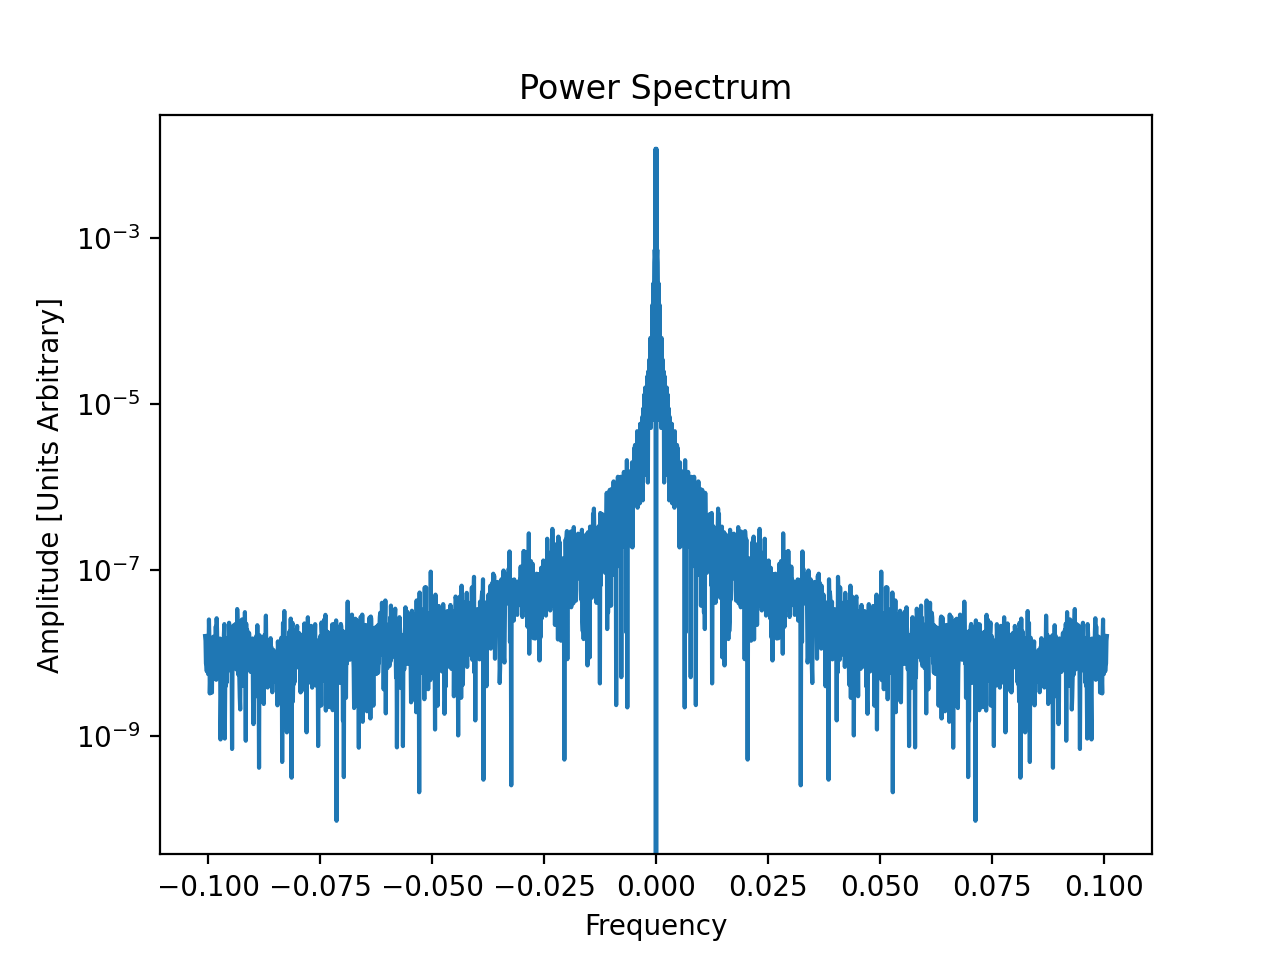

In [5]:
voltage_spectrum = np.fft.fft(m17_volts)
voltage_spectrum[0] = 0 # this is the same as subtracting the mean in the timeseries data 
power_spectrum = np.abs(voltage_spectrum)**2
frequencies = np.fft.fftfreq(len(power_spectrum), dt)

plt.figure()
plt.title("Power Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Amplitude [Units Arbitrary]")
plt.semilogy(np.fft.fftshift(frequencies), np.fft.fftshift(power_spectrum)) # shifting the arrays to read correctly

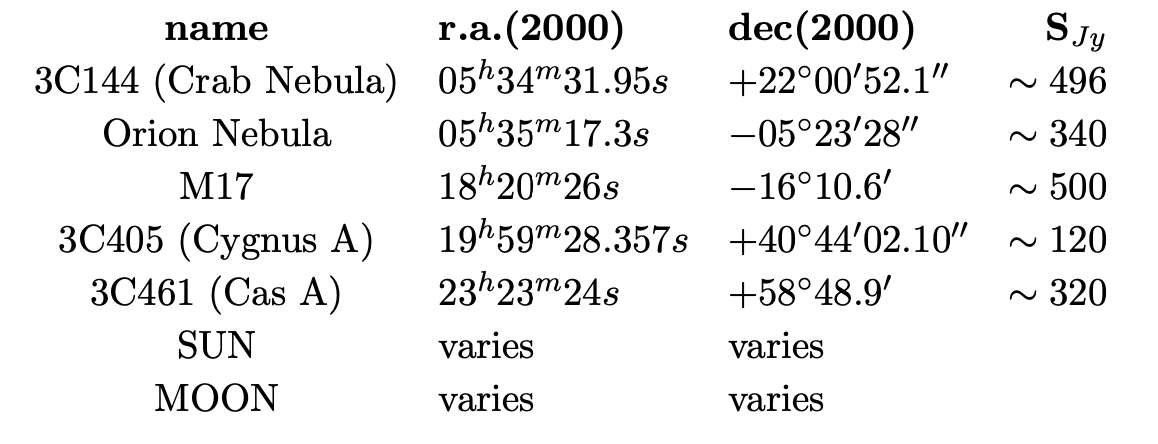


In [5]:
RA_deg= new_interf.time2deg(18, 20, 2)
print(RA_deg, "RA in degrees")
arc_dec= 10.6/60 #converting arc min to degrees 
arc_dec
dec = -16 - arc_dec
print(dec, "Dec in degrees")

precess_ra, precess_dec = ugradio.coord.precess(RA_deg, dec)
print("precess_ra is", precess_ra, "precess_dec is", precess_dec )
RA = np.radians(precess_ra)
Dec = np.radians(precess_dec)
print("RA is", RA, "Dec", Dec )

275.0083333333333 RA in degrees
-16.176666666666666 Dec in degrees
precess_ra is 275.007356180372 precess_dec is -16.17741001778704
RA is 4.799783832552269 Dec -0.2823490692554983


In [23]:
m17_times_JD= ugradio.timing.julian_date(m17_times)
m17_times_LST= ugradio.timing.lst(m17_times_JD)
print(m17_times_LST)
delta = Dec # declination 
B_ew = 20 # baseline east-west in meters
h_s = m17_times_LST - RA # hour angle = LST - RA
h_s = np.where(h_s<0, h_s +2*np.pi, h_s) # adding 2pi to when it is negative angles

wl = .0250  # wavelength in meters

[5.89881367 5.89917549 5.8995401  ... 0.38275616 0.38312076 0.38348537]


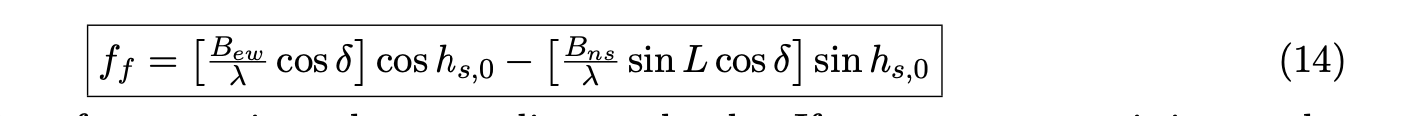


<IPython.core.display.Javascript object>


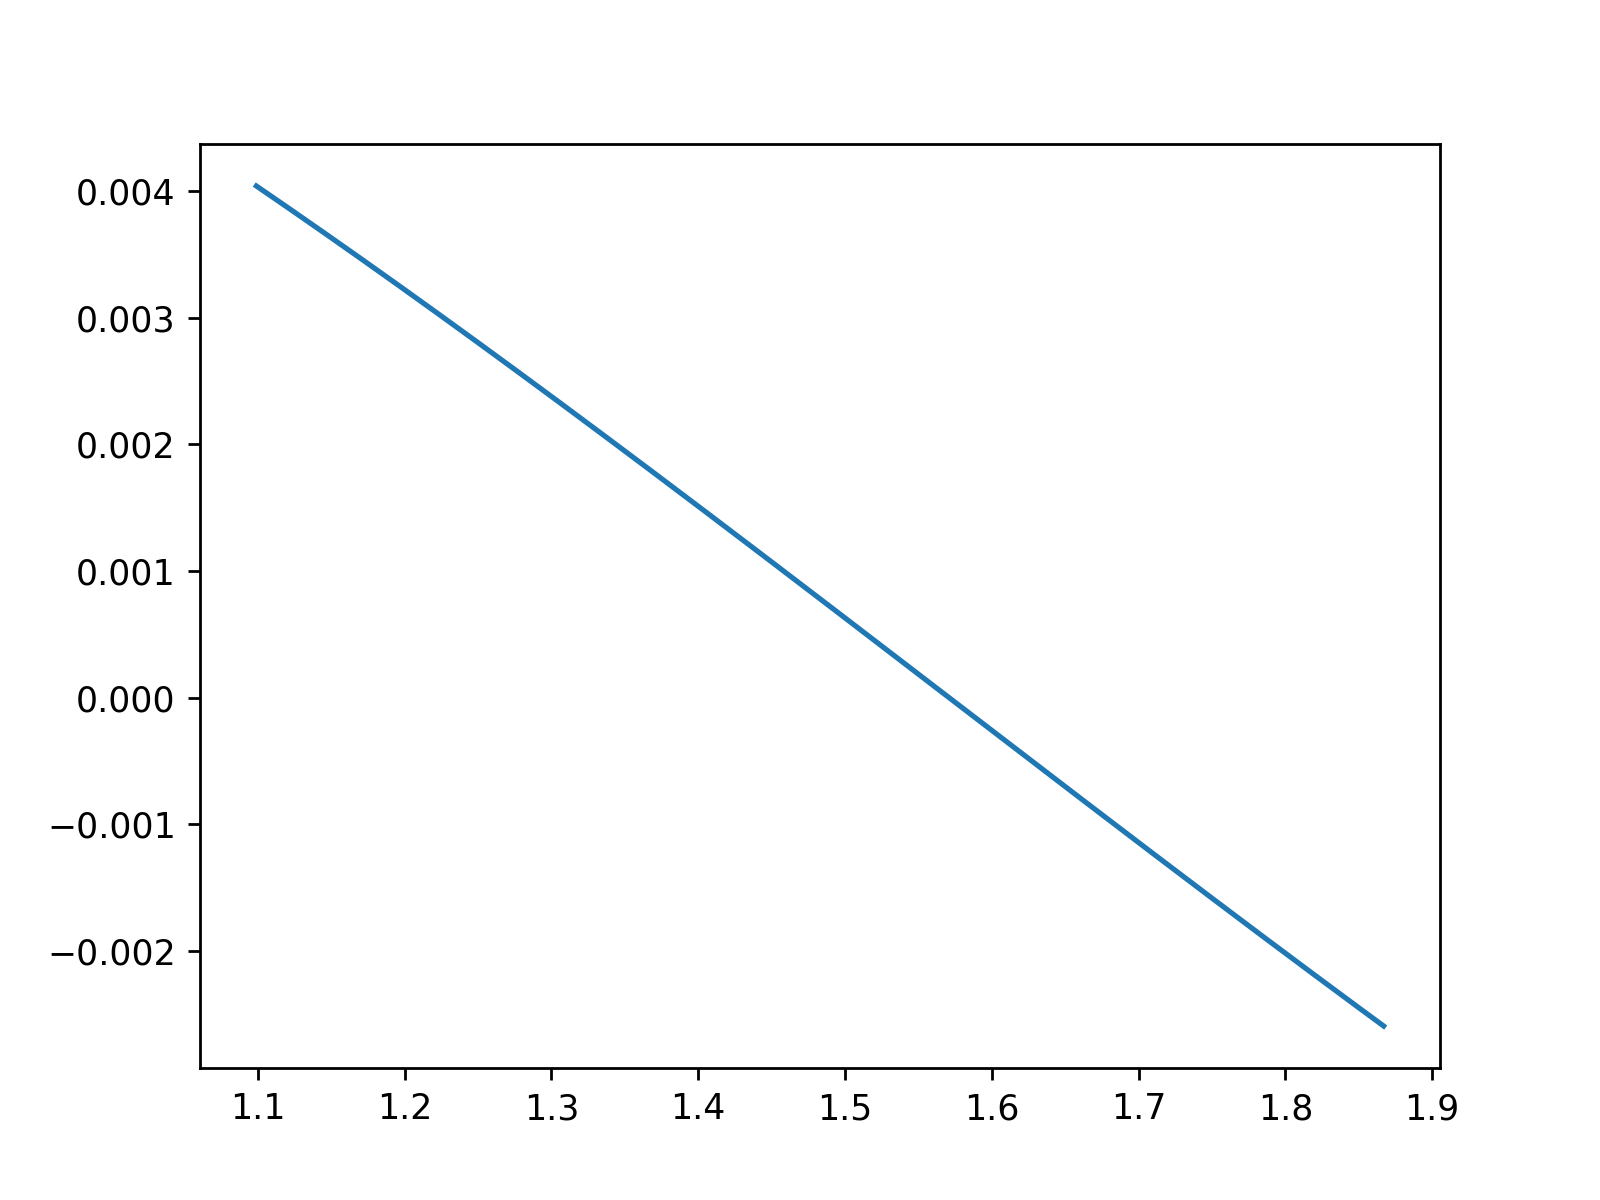

<IPython.core.display.Javascript object>


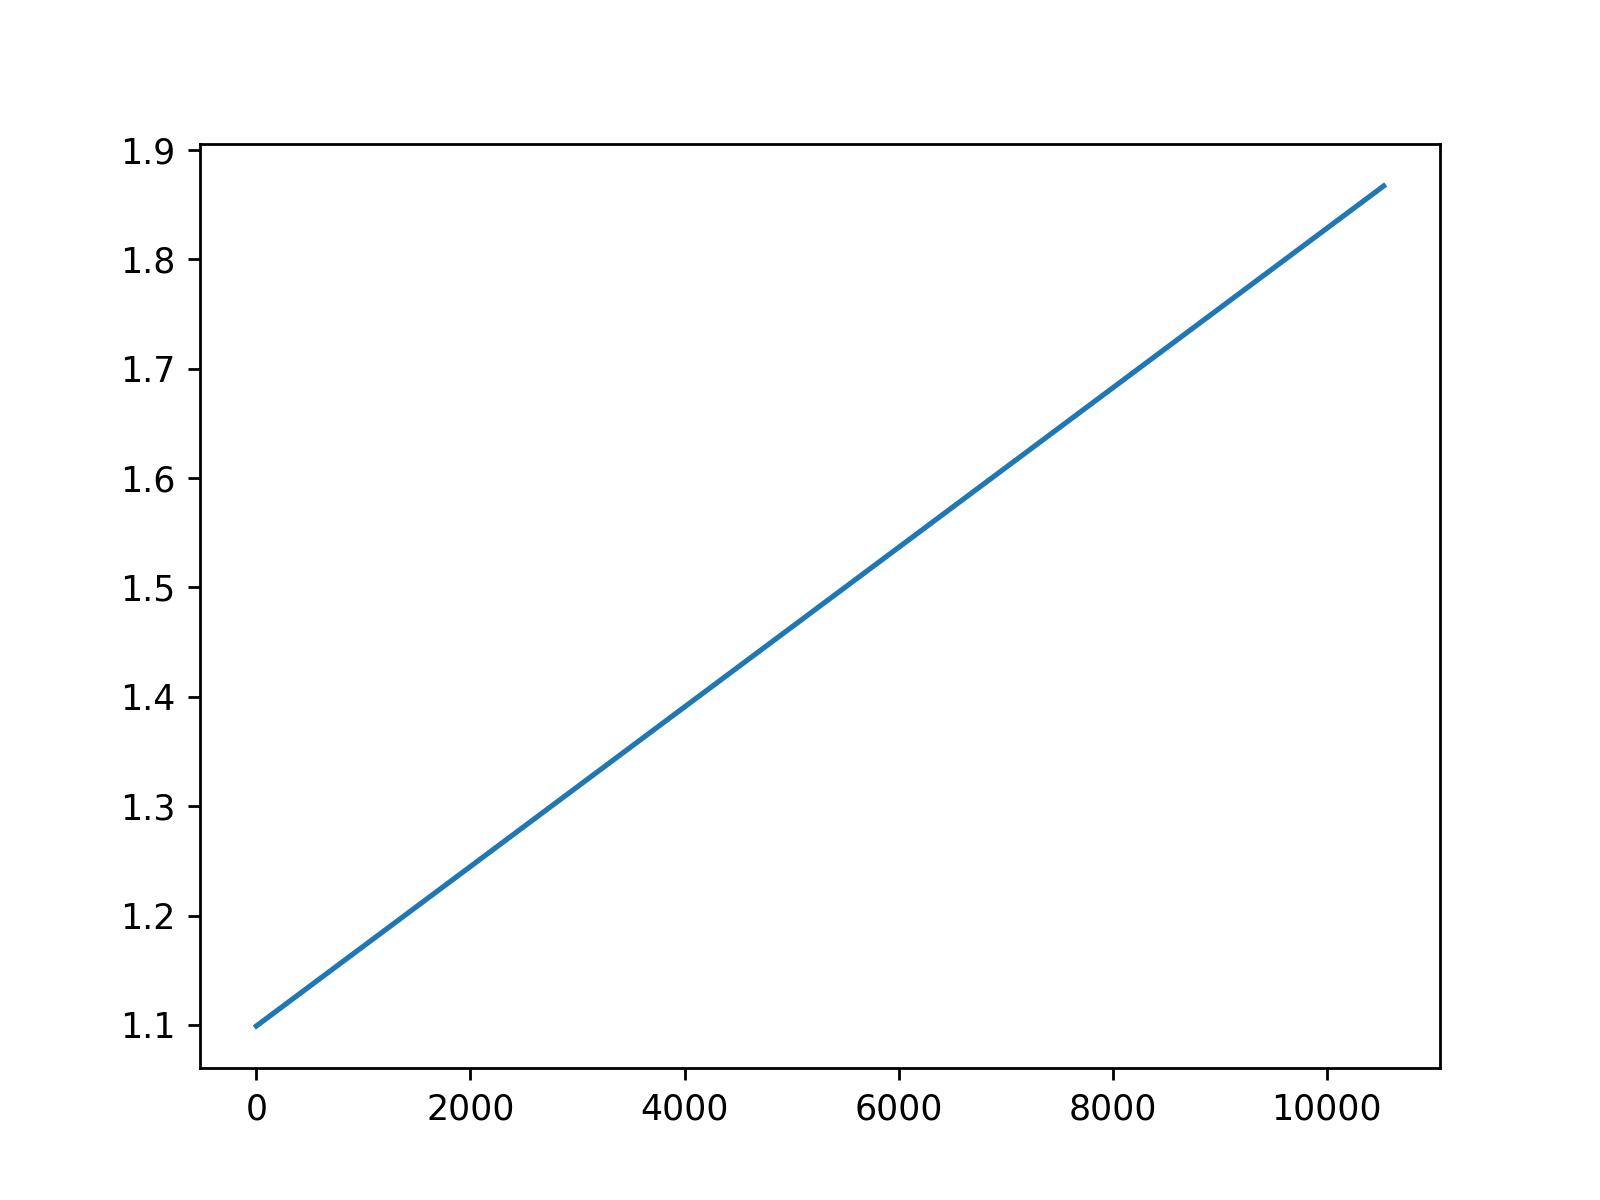

In [24]:
plt.figure()
f = (B_ew/wl * np.cos(delta)) * np.cos(h_s) # we are assuming baseline north-south is 0 
#which is not really true but whatever
f/=24*3600

plt.plot( h_s, f)
plt.figure()
plt.plot(m17_times, h_s)

# we think this is part of a cosine 
# these are the local fringe freqs

<IPython.core.display.Javascript object>


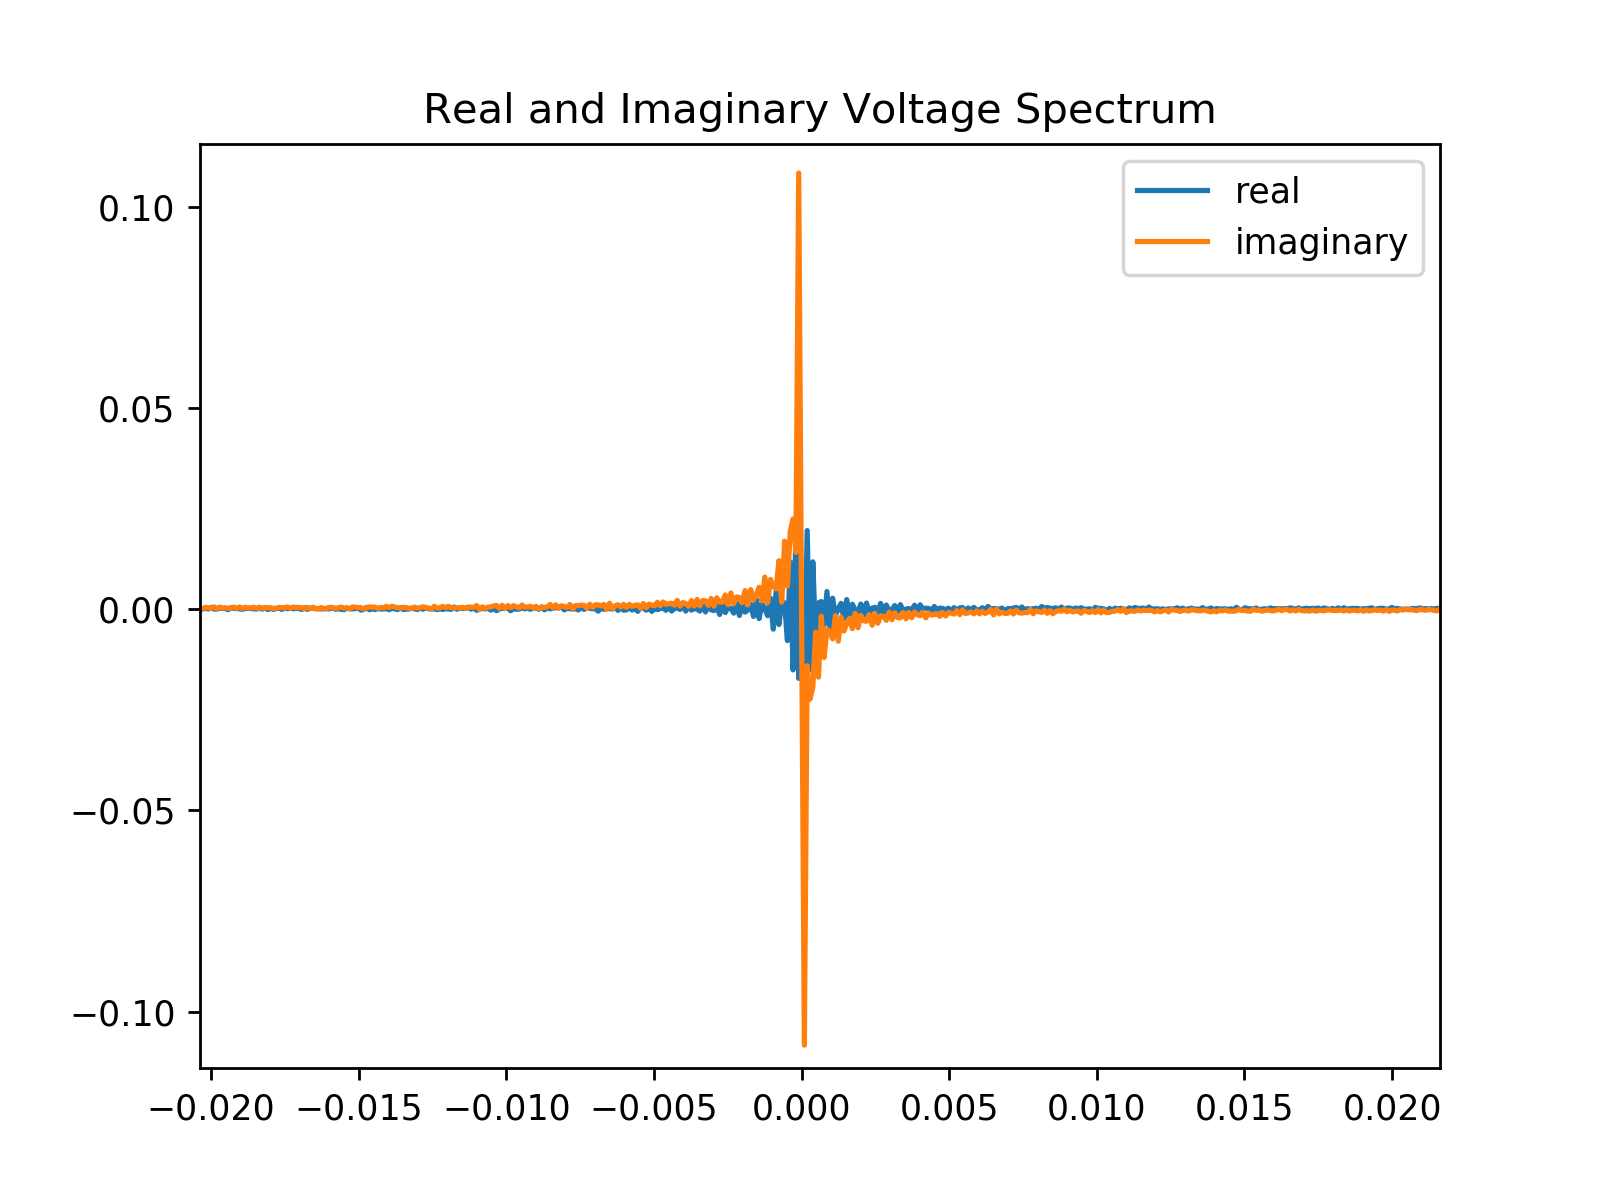

In [5]:
plt.figure()
plt.title("Real and Imaginary Voltage Spectrum")

plt.plot(np.fft.fftshift(frequencies), np.fft.fftshift(voltage_spectrum.real), label="real")
plt.plot(np.fft.fftshift(frequencies), np.fft.fftshift(voltage_spectrum.imag), label = "imaginary")# shifting the arrays to read correctly
plt.legend()

In [6]:
m17_spectra = new_interf.f_transform(m17_volts)
new_interf.f_transform??

<IPython.core.display.Javascript object>


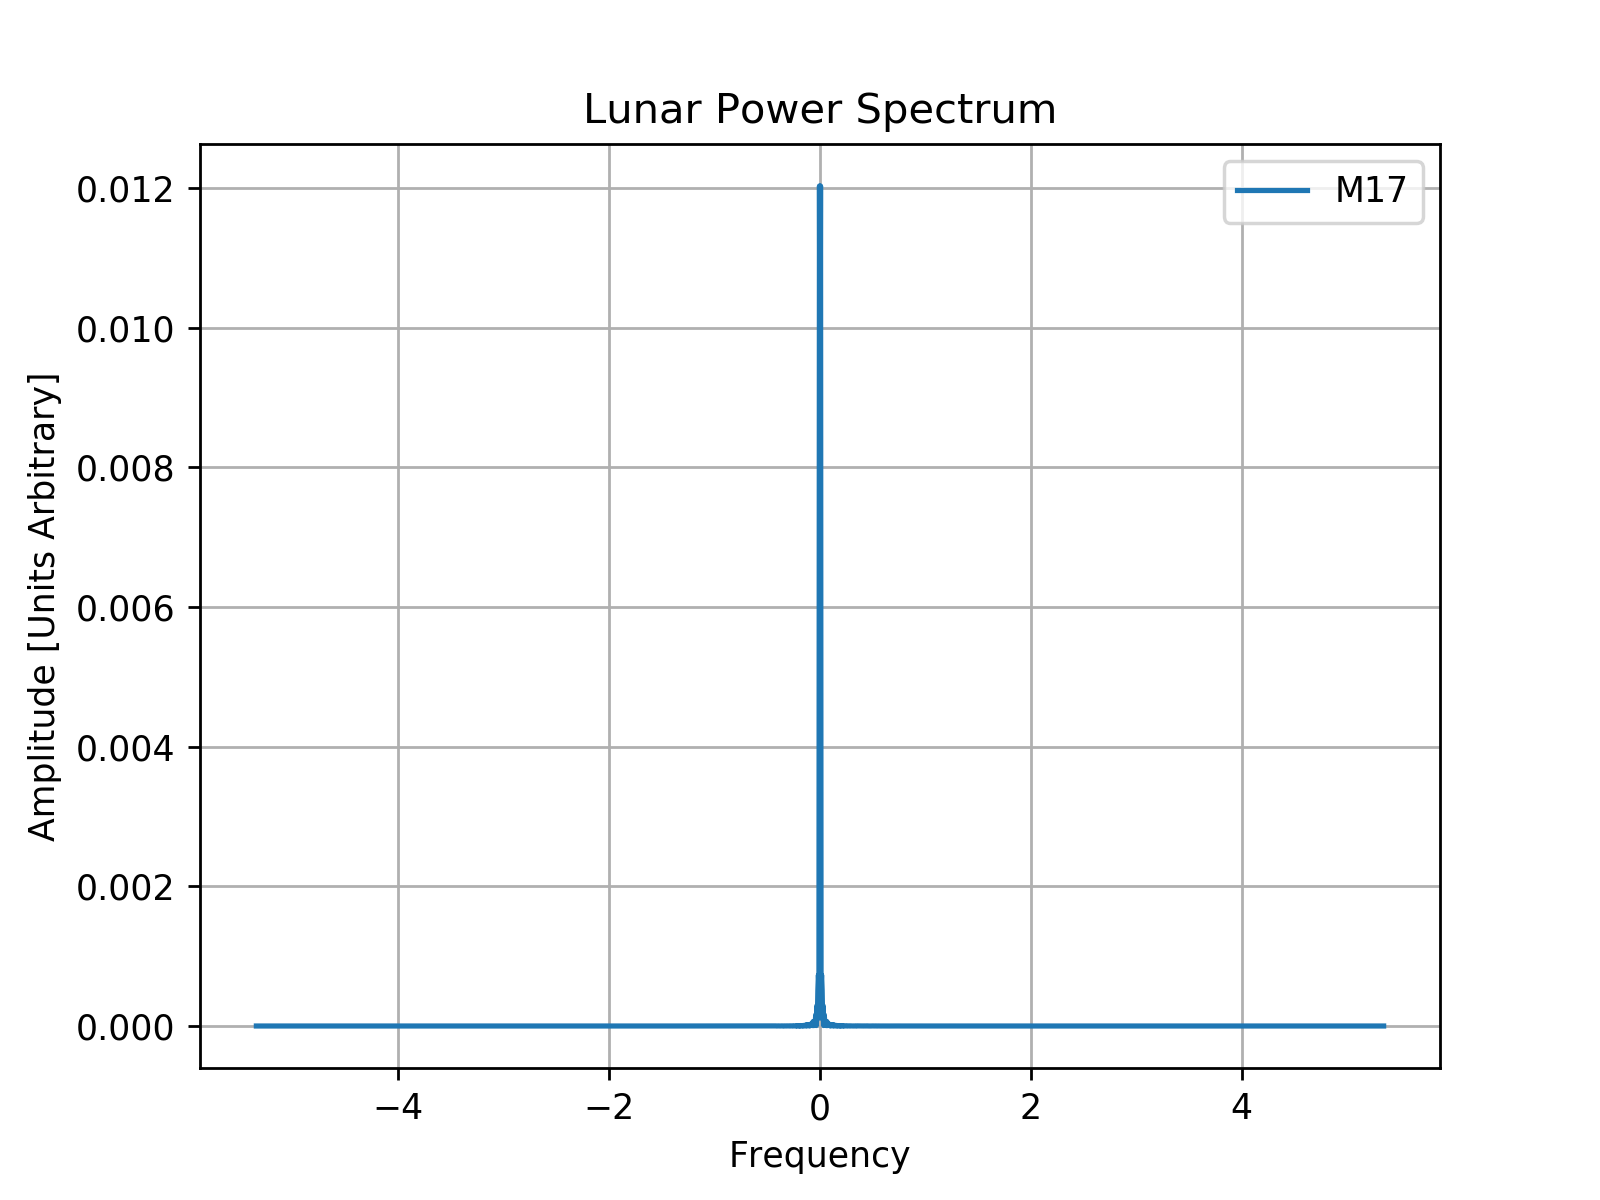

In [7]:
plt.figure()
plt.grid()
plt.title('Lunar Power Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Amplitude [Units Arbitrary]')
plt.plot(m17_spectra[0], m17_spectra[1], label = "M17")
plt.legend()
plt.show()


Alternative formulation of above plots using seaborn; below cell makes aesthetic changes

In [110]:
%matplotlib inline
sns.set_theme(style='ticks', palette='magma')

Text(0.5, 1.0, 'V vs t')

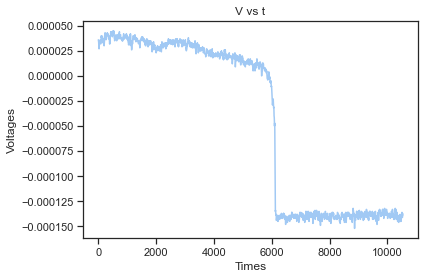

In [22]:
sns.lineplot(data=m17_data, y='Voltages', x='Times')
plt.title('V vs t')

In [94]:
other_data['Observation']=['Other']*len(other_data)
m17_data['Observation']=['M17']*len(m17_data)

df=pd.concat([m17_data, other_data], axis=0)

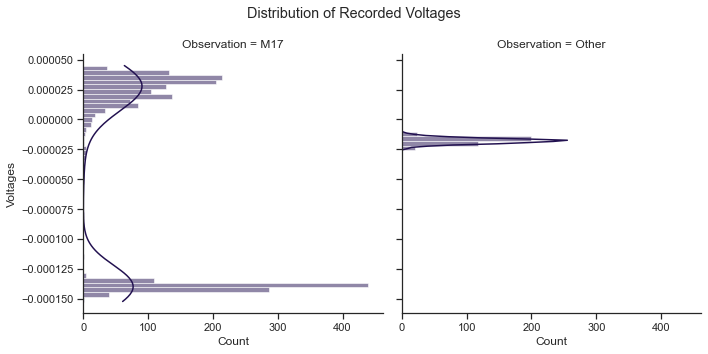

In [119]:
v_range = m17_data.Voltages.max()-m17_data.Voltages.min()
#show distribution of voltages
#fig, axes=plt.subplots(figsize=[16, 9], facecolor='#f1f1f1')
dis = sns.displot(data=df, y='Voltages', bins=50, kde=True, col='Observation', palette='magma')
dis.fig.suptitle('Distribution of Recorded Voltages')
dis.fig.subplots_adjust(top=0.85)

# Statistical Analysis of dataframe

In [43]:
m17_data.describe()

,Voltages,Times
count,2107.000000,2.107000e+03
mean,-0.000044,1.647453e+09
std,0.000082,3.041914e+03
min,-0.000152,1.647448e+09
25%,-0.000139,1.647451e+09
50%,0.000013,1.647453e+09
75%,0.000031,1.647456e+09
max,0.000045,1.647459e+09


In [46]:
v_range = m17_data.Voltages.max()-m17_data.Voltages.min()
v_range

0.00019700000000000002